# Package import

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

import matplotlib.font_manager as fm

# RegulonDB Data Processing

In [2]:
RegulonDB_Promoter_Set = pd.read_csv("../Data/RegulonDB_v13_08042024/PromoterSet.tsv", index_col=0, sep = '\t', comment='#')

# Precise1k and iModulon Data processing

## Load the data from ./Data/ folder

In [3]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [4]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [5]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

In [6]:
biocyc_info = pd.read_csv('../Data/biocyc_info.txt', sep="\t")

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [7]:
P1K_M = precise1k.M

In [8]:
P1K_A = precise1k.A

In [9]:
P1K_X = precise1k.X

In [10]:
P1K_log_tpm = precise1k.log_tpm

In [11]:
def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Identify rows with NaN 'Gene Name'
    removed_indices = merged_df[merged_df['Gene Name'].isna()]['Accession'].tolist()

    # Print the original indices that were removed
    print("Original indices removed due to NaN 'Gene Name':", removed_indices)

    # Set 'Gene Name' as the new index and drop the 'Accession' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [12]:
P1K_M = map_accession_to_gene_name(P1K_M, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [13]:
P1K_X = map_accession_to_gene_name(P1K_X, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [14]:
P1K_log_tpm = map_accession_to_gene_name(P1K_log_tpm, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [15]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

Original indices removed due to NaN 'Gene Name': []


In [16]:
P1K_merged = pd.read_csv('../Data/P1K_merged_with_Category.csv', index_col=0)

In [17]:
# Step 1: Calculate the ratio for the entire P1K_merged DataFrame
ratio = P1K_merged['Top_1_Explained_Variance'] / P1K_merged['Total_Explained_Variance']

# Step 2: Filter based on Total_Explained_Variance > 0.5 (Gene_Category_1) and < 0.5 (Gene_Category_2)
Gene_Category_1 = P1K_merged[P1K_merged['Total_Explained_Variance'] > 0.7]
Gene_Category_2 = P1K_merged[P1K_merged['Total_Explained_Variance'] < 0.7]

# Step 3: Recalculate the ratio for Gene_Category_1 to ensure index alignment
ratio_category_1 = Gene_Category_1['Top_1_Explained_Variance'] / Gene_Category_1['Total_Explained_Variance']

# Step 4: From Gene_Category_1, further split into Gene_Category_1_1 and Gene_Category_1_2 based on the recalculated ratio
Gene_Category_1_1 = Gene_Category_1[ratio_category_1 > 0.5]  # Where recalculated ratio > 0.5
Gene_Category_1_2 = Gene_Category_1[ratio_category_1 <= 0.5]  # Where recalculated ratio <= 0.5

In [18]:
Gene_Category_1_1_1 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] == 0]

In [19]:
Gene_Category_1_1_2 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] == 1]

In [20]:
Gene_Category_1_1_3 = Gene_Category_1_1[Gene_Category_1_1['num_regulators'] >= 2]

In [22]:
# Subset Gene_Category_2 into four categories based on MAD and num_regulators

# Category_2_1: MAD < 0.4
Gene_Category_2_1 = Gene_Category_2[Gene_Category_2['MAD'] < 0.4]

# Category_2_2: MAD > 0.4 and num_regulators > 1
Gene_Category_2_2 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] > 1)]

# Category_2_3: MAD > 0.4 and num_regulators == 1
Gene_Category_2_3 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] == 1)]

# Category_2_4: MAD > 0.4 and num_regulators == 0
Gene_Category_2_4 = Gene_Category_2[(Gene_Category_2['MAD'] > 0.4) & (Gene_Category_2['num_regulators'] == 0)]

# Check if all rows in Gene_Category_2 belong to one of the categories
# Combine all categories and check if their total number of rows equals Gene_Category_2
all_categories_combined = pd.concat([Gene_Category_2_1, Gene_Category_2_2, Gene_Category_2_3, Gene_Category_2_4])

# Check if all rows in Gene_Category_2 are in the combined categories
all_belong = all_categories_combined.shape[0] == Gene_Category_2.shape[0]

# Output the result of the check
print(f"All rows in Gene_Category_2 belong to one of the categories: {all_belong}")


All rows in Gene_Category_2 belong to one of the categories: True


## Example for Gene_Category_1_1_1

In [23]:
Gene_Category_1_1_1

,Total_Explained_Variance,Top_1_Explained_Variance,Top_1_iModulon,Top_2_Explained_Variance,Top_2_iModulon,Top_3_Explained_Variance,Top_3_iModulon,num_regulators,num_iM,MAD,log_TPM_median,range_log_tpm,quantile_range_log_tpm,Variance_Category,Expression_Category,Combined_Category
yaaJ,0.871146,0.603634,Fnr-2,0.272856,ppGpp,0.097127,Fnr-1,0,1,0.484317,3.382637,5.231202,3.233388,Medium Variance,Low Expression,Medium Variance - Low Expression
insL1,0.786396,0.588159,minicoli KOs,0.106634,RpoH,0.056453,IS Elements-1,0,1,0.341678,5.661573,8.107306,2.687845,Low Variance,Medium Expression,Low Variance - Medium Expression
insB1,0.794898,0.577758,IS1,0.163817,Cold Shock,0.150796,IS Elements-1,0,1,0.570320,2.440476,5.753319,3.593489,Medium Variance,Low Expression,Medium Variance - Low Expression
insA1,0.774757,0.576084,IS1,0.232821,Cold Shock,0.196298,minicoli KOs,0,1,0.613605,3.981928,6.638065,3.336632,Medium Variance,Low Expression,Medium Variance - Low Expression
rpsT,0.719152,0.567716,ppGpp,0.146225,Translation,0.087224,RpoS,0,1,0.613852,11.617342,10.959844,3.058403,Medium Variance,High Expression,Medium Variance - High Expression
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ynaL,0.870153,0.752836,RpoS,0.214785,PAL 10 Del,0.063041,rcsB KO,0,2,1.400803,4.594118,9.361632,7.788007,High Variance,Low Expression,High Variance - Low Expression
ynaM,0.859825,0.814377,Cold Shock,0.164788,LPS,0.052239,CCK-PGI Del,0,5,1.053900,3.945465,12.266527,9.296680,High Variance,Low Expression,High Variance - Low Expression
yneP,0.748917,0.629455,yneP,0.075002,GadXW,0.047460,Resistance,0,1,1.059936,1.140369,4.458041,2.868327,High Variance,Low Expression,High Variance - Low Expression
yqhI,0.894360,0.738529,yqhI,0.091457,UC-8,0.084815,Resistance,0,2,1.195671,1.195671,7.305199,4.985373,High Variance,Low Expression,High Variance - Low Expression


In [66]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name, save_path=None):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    plt.figure(figsize=(2, 2))
    
    # Create scatter plot with smaller points and no label for the legend
    plt.scatter(x_values, y_values, s=10, color='#2FA148', label='_nolegend_')  # Custom color points

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='black')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Set font properties for ticks and labels
    plt.xlabel(gene_name, fontproperties=font_prop)
    plt.ylabel(f'{imodulon_name} iM Activity', fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Use superscript 2 character (²) instead of LaTeX math mode for R-squared
    r2_text = f'R² = {r2:.2f}'
    
    # Display the legend with the custom font and the manually formatted R-squared text
    legend = plt.legend([r2_text], handlelength=0, handletextpad=0, loc='best', prop=font_prop)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


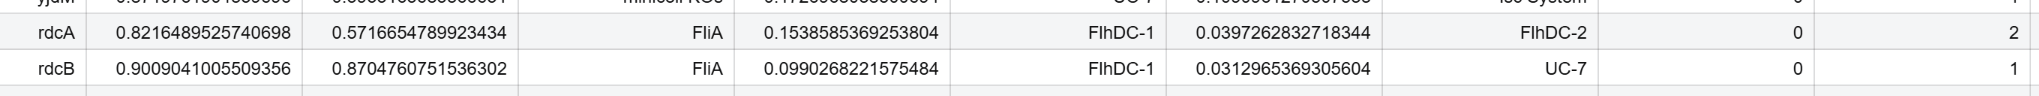

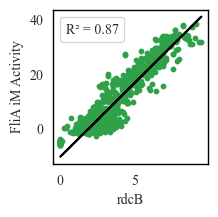

In [76]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'rdcB', 'FliA', save_path = 'Case_Study_Plots/rdcB_FliA_expression_activity_corr.svg')

## Example for Gene_Category_1_1_2

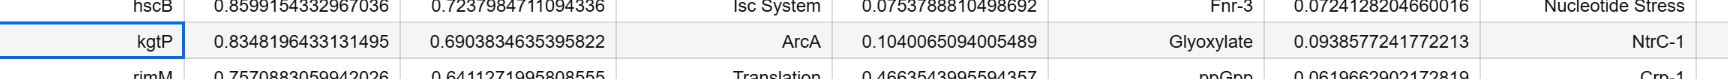

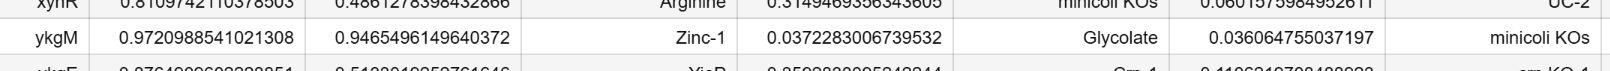

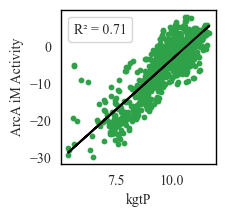

In [70]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'kgtP', 'ArcA')

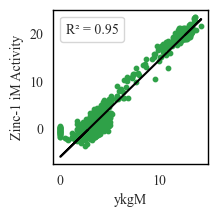

In [78]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'ykgM', 'Zinc-1', save_path = 'Case_Study_Plots/ykgM_Zinc_1_expression_activity_corr.svg')

## Example for Gene_Category_1_1_3

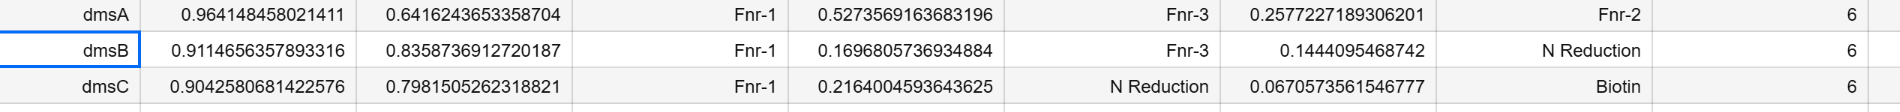

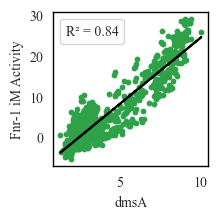

In [79]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'dmsA', 'Fnr-1', save_path = 'Case_Study_Plots/dmsA_Fnr_1_expression_activity_corr.svg')

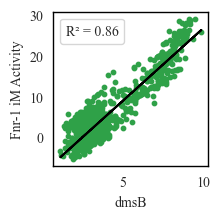

In [73]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'dmsB', 'Fnr-1')

## Example for Gene_Category_1_2

In [92]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter_with_fit(X, A, gene_name, imodulon_name, save_path=None):
    # Extract the rows
    x_values = X.loc[gene_name].values.reshape(-1, 1)
    y_values = A.loc[imodulon_name].values
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    plt.figure(figsize=(2, 2))
    
    # Create scatter plot with smaller points and no label for the legend
    plt.scatter(x_values, y_values, s=10, color='#D62A28', label='_nolegend_')  # Custom color points

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_values, y_values)
    y_pred = model.predict(x_values)
    
    # Plot the line of best fit
    plt.plot(x_values, y_pred, color='black')

    # Calculate the R^2 value
    r2 = r2_score(y_values, y_pred)
    
    # Set font properties for ticks and labels
    plt.xlabel(gene_name, fontproperties=font_prop)
    plt.ylabel(f'{imodulon_name} iM Activity', fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)

    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Use superscript 2 character (²) instead of LaTeX math mode for R-squared
    r2_text = f'R² = {r2:.2f}'
    
    # Display the legend with the custom font and the manually formatted R-squared text
    legend = plt.legend([r2_text], handlelength=0, handletextpad=0, loc='upper left', prop=font_prop)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


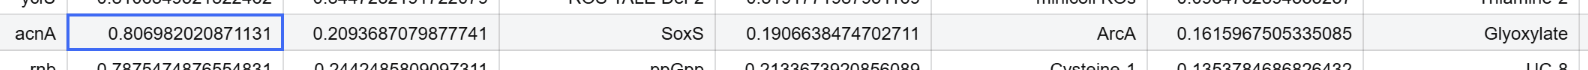

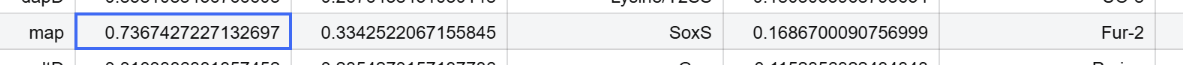

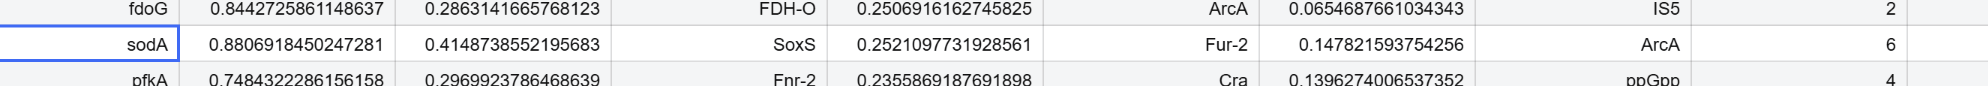

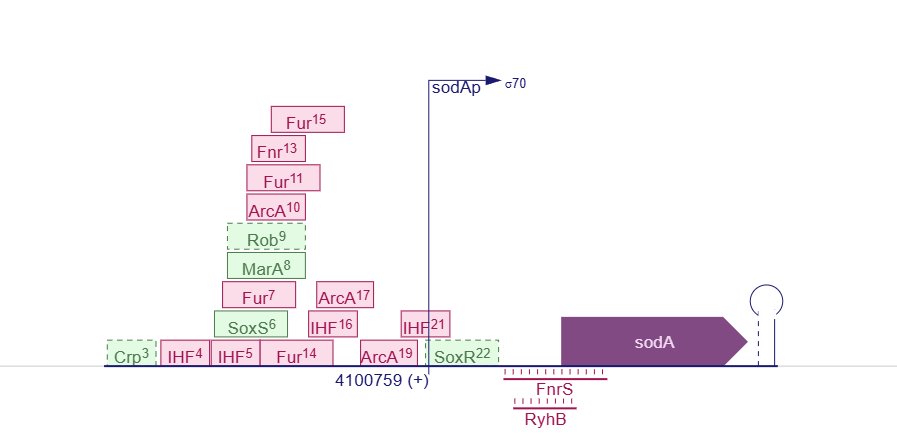

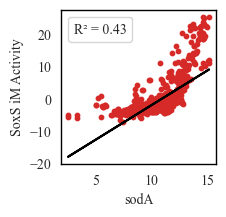

In [93]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'sodA', 'SoxS', save_path = 'Case_Study_Plots/sodA_SoxS_expression_activity_corr.svg')

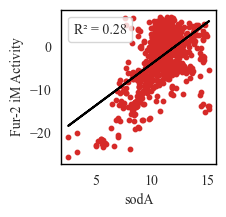

In [94]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'sodA', 'Fur-2', save_path = 'Case_Study_Plots/sodA_Fur_expression_activity_corr.svg')

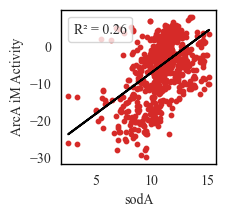

In [95]:
plot_scatter_with_fit(P1K_log_tpm, P1K_A, 'sodA', 'ArcA', save_path = 'Case_Study_Plots/sodA_ArcA_expression_activity_corr.svg')

## Category_2_1 - No Activation Condition in PRECISE-1K

In [296]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_row_histogram(df, row_index, save_path=None):
    """
    Plots a histogram of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot the histogram for.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    
    plt.figure(figsize=(3, 2))
    
    # Plot the histogram of the row values
    plt.hist(row_values, bins=10, color='#9268AD')  # Custom color for the histogram

    # Set x-axis limit and tick positions
    plt.xlim(-1, 13)
    plt.xticks([0, 3, 6, 9, 12], fontproperties=font_prop)

    # Set labels and title using the custom font
    plt.xlabel(f'{row_index} Gene Expression - log2(TPM+1)', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)
    
    # Apply font properties to y-axis tick labels and force y-axis ticks at 100, 200, 300, 400, 500
    plt.yticks([100, 200, 300, 400, 500, 600], fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)
    
    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


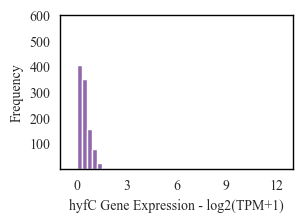

In [297]:
plot_row_histogram(P1K_log_tpm, 'hyfC', save_path='Case_Study_Plots/hyfC_expression_distribution.svg')

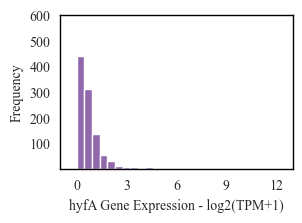

In [298]:
plot_row_histogram(P1K_log_tpm, 'hyfA', save_path='Case_Study_Plots/hyfA_expression_distribution.svg')

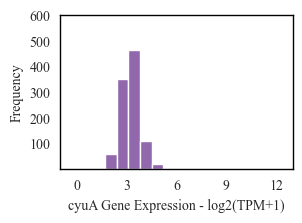

In [300]:
plot_row_histogram(P1K_log_tpm, 'cyuA', save_path='Case_Study_Plots/cyuA_expression_distribution.svg')

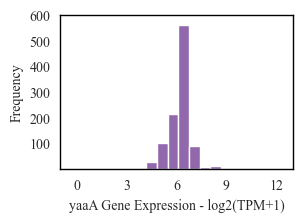

In [266]:
plot_row_histogram(P1K_log_tpm, 'yaaA', save_path='Case_Study_Plots/yaaA_expression_distribution.svg')

In [177]:
def plot_row_data(df, row_index, save_path=None):
    """
    Plots a bar plot of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    print("Data values (first 10):", row_values[:10])  # Inspect first 10 values
    print("Max value:", np.max(row_values))  # Inspect the max value for context
    
    # Ensure the values are not too small for visibility (adjust for small values)
    if np.all(row_values < 1):
        row_values = row_values * 1000  # Scale the values up for visibility
    
    x_values = np.arange(len(row_values))  # X-axis values, one for each data point
    
    # Increase the figure size for better visibility
    plt.figure(figsize=(50, 2))  # Adjust the figure size
    
    # Use a bar plot for data visualization
    plt.bar(x_values, row_values, color='#9268AD')

    # Set labels and title using the custom font
    plt.xlabel('PRECISE-1K samples', fontproperties=font_prop)
    plt.ylabel('Log2(TPM+1)', fontproperties=font_prop)
    
    # Ensure the Y-axis starts from 0 and adjust for better visibility
    plt.ylim(0, max(row_values) * 1.1)  # Ensure space above max value
    plt.axhline(0, color='black', linewidth=1)  # Set baseline at y=0

    # Apply font properties to tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


Data values (first 10): [0.23431531 0.84116813 0.59322192 1.08432262 0.58305649 0.44226949
 0.68301627 0.75547972 0.28083868 0.74623993]
Max value: 3.053981911


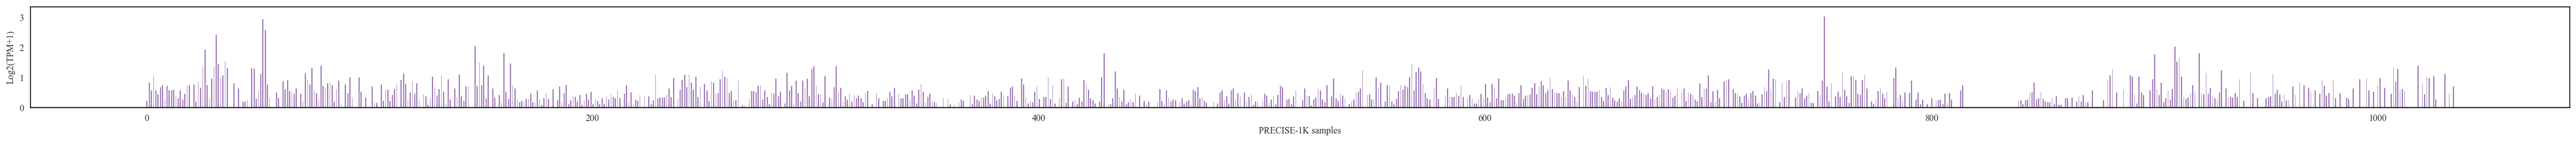

In [178]:
plot_row_data(P1K_log_tpm, 'hyfC')#, save_path='Case_Study_Plots/hyfC_expression.svg')

## Category_2_2 - Multiple Regulator

In [227]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd

def ICA_explained_variance_single_gene(
    M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix, gene, samples=None, imodulons=None, save_path=None
):
    # Check if gene is valid
    if gene not in log_tpm.index:
        raise ValueError(f"Gene {gene} not found in log_tpm.")

    # Select the gene expression values
    gene_expression = log_tpm.loc[gene]
    
    if samples is None:
        samples = log_tpm.columns
    elif isinstance(samples, str):
        samples = [samples]

    if imodulons is None:
        imodulons = M_matrix.columns
    elif isinstance(imodulons, str) or isinstance(imodulons, int):
        imodulons = [imodulons]

    # Normalize the gene expression values
    centered = gene_expression.subtract(gene_expression.mean())
    baseline = centered[samples].values

    # Initialize variables
    base_err = np.linalg.norm(baseline) ** 2
    MA = np.zeros(len(samples))
    rec_var = [0]
    ma_arrs = {}
    explained_variance = []
    i = 0
    
    # Get individual modulon contributions
    for k in imodulons:
        ma_arr = (
            M_matrix.loc[gene, k] * A_matrix.loc[k, samples].values
        )
        ma_arrs[k] = ma_arr

    # Calculate explained variance for each component
    for k in imodulons:
        MA += ma_arrs[k]
        sa_err = np.linalg.norm(MA - baseline) ** 2
        rec_var.append((1 - sa_err / base_err))
        explained_variance.append((k, rec_var[i+1] - rec_var[i]))
        i += 1

    # Create a DataFrame from the collected data and sort by explained variance
    explained_variance_df = pd.DataFrame(explained_variance, columns=['iModulon', 'Explained Variance'])
    explained_variance_df = explained_variance_df.sort_values(by='Explained Variance', ascending=False)
    
    # Select the top 20 and lowest 20 based on explained variance
    top_20 = explained_variance_df.head(30)
    bottom_20 = explained_variance_df.tail(30)
    combined_df = pd.concat([top_20, bottom_20])

    # Add Presence column
    combined_df['Presence'] = combined_df['iModulon'].apply(
        lambda x: 'Yes' if P1K_Gene_Presence_Matrix.loc[gene, x] else 'No'
    )
    
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Plot the explained variance for the selected iModulons
    plt.figure(figsize=(3.5, 2))
    plt.bar(combined_df['iModulon'], combined_df['Explained Variance'], color = '#8D574C')
    plt.xlabel('iModulon', fontproperties=font_prop)
    plt.ylabel('Explained Variance', fontproperties=font_prop)
    # plt.title(f'Explained Variance by iModulon for Gene {gene}', fontproperties=font_prop)
    plt.title('', fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black border around the plot
    plt.gca().spines['top'].set_linewidth(1.0)
    plt.gca().spines['bottom'].set_linewidth(1.0)
    plt.gca().spines['left'].set_linewidth(1.0)
    plt.gca().spines['right'].set_linewidth(1.0)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

    # Set font properties for ticks
    plt.xticks(fontproperties=font_prop, fontsize=10)  # Adjust fontsize for x-ticks
    plt.yticks(fontproperties=font_prop)

    # Remove x-ticks
    plt.xticks([])

    # If a save_path is provided, save the plot to the specified path as an SVG file
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    plt.show()
    
    return combined_df


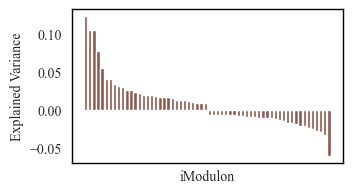

,iModulon,Explained Variance,Presence
91,NDH-1,0.123127,No
134,Crp-2,0.105218,No
74,ArcA,0.104850,No
86,UC-3,0.077151,No
167,UC-2,0.055606,No
145,ppGpp,0.041314,No
51,RpoS,0.041063,No
84,NtrC-2,0.034710,No
185,gcvB,0.031331,No
127,Cold Shock,0.030314,No


In [228]:
ICA_explained_variance_single_gene(P1K_M, P1K_A, P1K_log_tpm, P1K_Gene_Presence_Matrix, 'sucA', save_path = 'Case_Study_Plots/sucA_exp_var_cumulative.svg')

In [229]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

def ICA_explained_variance_single_gene(
    M_matrix, A_matrix, log_tpm, P1K_Gene_Presence_Matrix, gene, samples=None, imodulons=None, save_path=None
):
    # Check if gene is valid
    if gene not in log_tpm.index:
        raise ValueError(f"Gene {gene} not found in log_tpm.")

    # Select the gene expression values
    gene_expression = log_tpm.loc[gene]
    
    if samples is None:
        samples = log_tpm.columns
    elif isinstance(samples, str):
        samples = [samples]

    if imodulons is None:
        imodulons = M_matrix.columns
    elif isinstance(imodulons, str) or isinstance(imodulons, int):
        imodulons = [imodulons]

    # Normalize the gene expression values
    centered = gene_expression.subtract(gene_expression.mean())
    baseline = centered[samples].values

    # Initialize variables
    base_err = np.linalg.norm(baseline) ** 2
    MA = np.zeros(len(samples))
    rec_var = [0]
    ma_arrs = {}
    explained_variance = []
    i = 0
    
    # Get individual modulon contributions
    for k in imodulons:
        ma_arr = (
            M_matrix.loc[gene, k] * A_matrix.loc[k, samples].values
        )
        ma_arrs[k] = ma_arr

    # Calculate explained variance for each component
    for k in imodulons:
        MA += ma_arrs[k]
        sa_err = np.linalg.norm(MA - baseline) ** 2
        rec_var.append((1 - sa_err / base_err))
        explained_variance.append((k, rec_var[i+1] - rec_var[i]))
        i += 1

    # Create a DataFrame from the collected data and sort by explained variance
    explained_variance_df = pd.DataFrame(explained_variance, columns=['iModulon', 'Explained Variance'])
    explained_variance_df = explained_variance_df.sort_values(by='Explained Variance', ascending=False)
    
    # Select the top 20 and lowest 20 iModulons
    top_20 = explained_variance_df.head(30)
    bottom_20 = explained_variance_df.tail(30)
    combined_df = pd.concat([top_20, bottom_20])

    # Add Presence column
    combined_df['Presence'] = combined_df['iModulon'].apply(
        lambda x: 'Yes' if P1K_Gene_Presence_Matrix.loc[gene, x] else 'No'
    )
    
    # Load custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Plot the negative explained variance for each iModulon, with reversed x-axis order
    plt.figure(figsize=(3.5, 2))
    # Multiply the explained variance values by -1 for negative values and reverse the order of the x-axis
    plt.bar(combined_df['iModulon'][::-1], -combined_df['Explained Variance'][::-1], color='#BCBE32')
    plt.xlabel('iModulon', fontproperties=font_prop)
    plt.ylabel('Explained Variance', fontproperties=font_prop)
    plt.title('', fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black border around the plot
    plt.gca().spines['top'].set_linewidth(1.0)
    plt.gca().spines['bottom'].set_linewidth(1.0)
    plt.gca().spines['left'].set_linewidth(1.0)
    plt.gca().spines['right'].set_linewidth(1.0)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

    # Set font properties for ticks
    plt.xticks(fontproperties=font_prop, fontsize=10)  # Adjust fontsize for x-ticks

    # Format y-ticks to two decimal places
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

    plt.yticks(fontproperties=font_prop)

    # Remove x-ticks
    plt.xticks([])

    # If a save_path is provided, save the plot to the specified path as an SVG file
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    plt.show()
    
    return combined_df


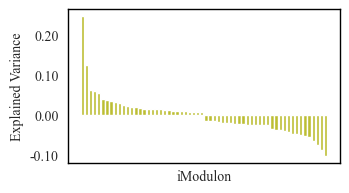

,iModulon,Explained Variance,Presence
176,Suf System,0.102871,No
182,Fatty Acid,0.085996,No
21,Nucleoside,0.074782,No
164,minicoli KOs,0.065115,No
196,Glyoxylate,0.054785,No
195,Phage Shock,0.051271,No
179,Maltose,0.050001,No
62,Fnr-1,0.047515,No
53,UC-1,0.046884,No
197,CCK-PGI Del,0.042613,No


In [230]:
ICA_explained_variance_single_gene(P1K_M, P1K_A, P1K_log_tpm, P1K_Gene_Presence_Matrix, 'mltA', save_path = 'Case_Study_Plots/mltA_exp_var_cumulative.svg')

In [271]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_row_histogram(df, row_index, save_path=None):
    """
    Plots a histogram of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot the histogram for.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    
    plt.figure(figsize=(3, 2))
    
    # Plot the histogram of the row values
    plt.hist(row_values, bins=10, color='#BCBE32')  # Custom green color for the histogram

    # Set labels and title using the custom font
    plt.xlabel(f'{row_index} Gene Expression - log2(TPM+1)', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)
    
    # Apply font properties to tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
        # Set x-axis limit and tick positions
    plt.xlim(-1, 13)
    plt.xticks([0, 3, 6, 9, 12], fontproperties=font_prop)
    plt.yticks([100, 200, 300], fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)

    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

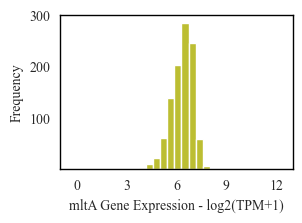

In [272]:
plot_row_histogram(P1K_log_tpm, 'mltA', save_path='Case_Study_Plots/mltA_expression_distribution.svg')

In [273]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_row_histogram(df, row_index, save_path=None):
    """
    Plots a histogram of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot the histogram for.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    
    plt.figure(figsize=(3, 2))
    
    # Plot the histogram of the row values
    plt.hist(row_values, bins=10, color='#8D574C')  # Custom green color for the histogram

    # Set labels and title using the custom font
    plt.xlabel(f'{row_index} Gene Expression - log2(TPM+1)', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)
    
    # Apply font properties to tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)
    
    # Set x-axis limit and tick positions
    plt.xlim(-1, 13)
    plt.xticks([0, 3, 6, 9, 12], fontproperties=font_prop)
    plt.yticks([100, 200, 300], fontproperties=font_prop)
    
    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

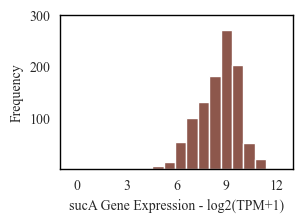

In [274]:
plot_row_histogram(P1K_log_tpm, 'sucA', save_path='Case_Study_Plots/sucA_expression_distribution.svg')

## No regulator case study

In [293]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_row_histogram(df, row_index, save_path=None):
    """
    Plots a histogram of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot the histogram for.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    
    plt.figure(figsize=(3, 2))
    
    # Plot the histogram of the row values
    plt.hist(row_values, bins=10, color='#1FBFD0')  # Custom green color for the histogram

    # Set labels and title using the custom font
    plt.xlabel(f'{row_index} Gene Expression - log2(TPM+1)', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)
    
    # Apply font properties to tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)
    
    # Set x-axis limit and tick positions
    plt.xlim(-1, 13)
    plt.xticks([0, 3, 6, 9, 12], fontproperties=font_prop)
    plt.yticks([100, 200, 300], fontproperties=font_prop)
    
    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

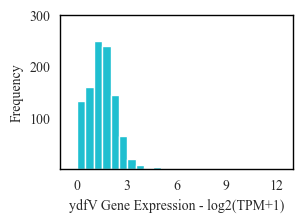

In [294]:
plot_row_histogram(P1K_log_tpm, 'ydfV', save_path='Case_Study_Plots/ydfV_expression_distribution.svg')

In [291]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_row_histogram(df, row_index, save_path=None):
    """
    Plots a histogram of the values in the given row index of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    row_index (int or string): Index of the row to plot the histogram for.
    save_path (string, optional): Path to save the plot as an SVG. If not provided, the plot is not saved.
    """
    
    # Set custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Extract the values from the specified row
    row_values = df.loc[row_index].values
    
    plt.figure(figsize=(3, 2))
    
    # Plot the histogram of the row values
    plt.hist(row_values, bins=10, color='#A9E3E8')  # Custom green color for the histogram

    # Set labels and title using the custom font
    plt.xlabel(f'{row_index} Gene Expression - log2(TPM+1)', fontproperties=font_prop)
    plt.ylabel('Frequency', fontproperties=font_prop)
    
    # Apply font properties to tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove the grid
    plt.grid(False)
    
    # Set x-axis limit and tick positions
    plt.xlim(-1, 13)
    plt.xticks([0, 3, 6, 9, 12], fontproperties=font_prop)
    plt.yticks([100, 200, 300, 400, 500], fontproperties=font_prop)
    
    # Add a black box surrounding the plot with a width of 1
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)

    # Save the plot to an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

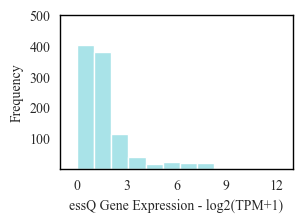

In [292]:
plot_row_histogram(P1K_log_tpm, 'essQ', save_path='Case_Study_Plots/essQ_expression_distribution.svg')